### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from pandas import DatetimeIndex

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### Carregamento de dados

In [2]:
dataOriginal = pd.read_excel('Global_Superstore2.xlsx', index_col=0, comment='#') 
df = dataOriginal 

### Tratamento dos dados

In [3]:
df['Ship Mode'] = df['Ship Mode'].astype('category')
df['Segment'] = df['Segment'].astype('category')
df['City'] = df['Country'].astype('category')
df['State'] = df['Country'].astype('category')
df['Country'] = df['Country'].astype('category')
df['Market'] = df['Market'].astype('category')
df['Region'] = df['Region'].astype('category')
df['Category'] = df['Category'].astype('category')
df['Sub-Category'] = df['Sub-Category'].astype('category')
#df['Orde Priority'] = df['Order Priority'].astype('category')

if df['Profit'].isnull().sum() > 0:
    df = df[df['Profit'].notna()]

In [4]:
# Já está justificado no ficheiro data_exploration o porquê de removermos Códigos postais.
if 'Postal Code' in df.columns:
    df = df.drop('Postal Code', axis=1)
 

df = df.rename(columns = {'Shipping Cost':'Shipping_Cost'})
df = df.rename(columns = {'Order Priority':'Order_Priority'})

#data['Product Name'] = data['Product Name'].mode().iloc[0]
#data.Order_Priority = most_imputer2.fit_transform(data[['Order_Priority']])

print("Total de valores nulos ")
print(df.isnull().sum())

Total de valores nulos 
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
City              0
State             0
Country           0
Market            0
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
Quantity          0
Discount          0
Profit            0
Shipping_Cost     0
Order_Priority    0
dtype: int64


In [5]:
def show_frequencies_categorys():
    for coluna in df.select_dtypes(exclude=["number","bool_", "float64"]).columns:
        #print(coluna)
        if df[coluna].nunique() > 10 and ("Date" not in coluna) and ("ID" not in coluna):

            
            #df2=dfgroupby([coluna])[coluna].sum().rename("Courses_fee").groupby(level = 0).transform(lambda x: x/x.sum())
            coluna_percentagens = (df[coluna].value_counts()/df[coluna].count())*100
           # print(coluna_percentagens)
           # print("Exp:")
            values = coluna_percentagens.groupby(coluna_percentagens > 1).filter(lambda x: x.mean() > 1)
            if values.size > 0:
                print("\n", coluna, "'s com mais de 1% de valores\n")
                print(values)


# Juntar países e cidades cuja frequência é menor que uma especificada, para dados categóricos
# Esses dados são: "State", "City", "Country", "Market", "Region"
percentage = 1

dataset = df
for coluna in ["State", "City", "Country", "Market", "Region" ]:

        #print(coluna)
        series = dataset.value_counts(dataset[coluna])
        mask = (series/series.sum() * 100).lt(percentage)
        #print(mask,"\n\n")
        dataset[coluna] = np.where(dataset[coluna].isin(series[mask].index),'Other',dataset[coluna])

df = dataset

show_frequencies_categorys()


 City 's com mais de 1% de valores

Other                 24.707031
United States         19.343750
Australia              5.541016
France                 5.521484
Mexico                 5.164062
Germany                4.033203
China                  3.671875
United Kingdom         3.189453
Brazil                 3.123047
India                  3.037109
Indonesia              2.714844
Turkey                 2.691406
Italy                  2.164062
Nigeria                1.767578
Spain                  1.677734
Dominican Republic     1.449219
El Salvador            1.437500
Cuba                   1.414062
Honduras               1.392578
Philippines            1.330078
New Zealand            1.226562
Nicaragua              1.199219
Iran                   1.185547
Guatemala              1.017578
Name: City, dtype: float64

 State 's com mais de 1% de valores

Other                 24.707031
United States         19.343750
Australia              5.541016
France                 5.521484
Me

In [6]:
data = df
number_bins = 6

from pandas.api.types import is_numeric_dtype

if is_numeric_dtype(data['Discount']):
    # Bins in discount
    print("0 ", data['Discount'])
    min_value = data['Discount'].min()
    print("1", min_value)
    max_value = data['Discount'].max()
    print("2", max_value)
    limits_bins = np.linspace(min_value,max_value , num=number_bins)
    print("3", limits_bins)
    labels_names = []
    for i in range(0, len(limits_bins) - 1):
#    print("Olá")   
        v1 = '{:.2f}'.format(limits_bins[i])
        v2 = '{:.2f}'.format(limits_bins[i+1])
        labels_names.append(f'{v1}-{v2}')
    #print("v1: ", limits_bins[i])
    #print("v2: ", limits_bins[i+1])
    #print("----")
#    data4.loc[data4['score'].between(0, 50, 'both'), 'grade'] = 'C'
#print(labels_names)
    data['Discount'] = pd.cut(x = data['Discount'], bins = limits_bins, labels = labels_names, include_lowest = True)
    print(data)
df = data

0  Row ID
32298    0.0
26341    0.1
25330    0.1
13524    0.1
47221    0.0
        ... 
24175    0.1
29002    0.0
35398    0.8
9596     0.0
6147     0.0
Name: Discount, Length: 51200, dtype: float64
1 0.0
2 0.85
3 [0.   0.17 0.34 0.51 0.68 0.85]
               Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
Row ID                                                                        
32298    CA-2012-124891  31-07-2012  31-07-2012        Same Day    RH-19495   
26341     IN-2013-77878  05-02-2013  07-02-2013    Second Class    JR-16210   
25330     IN-2013-71249  17-10-2013  18-10-2013     First Class    CR-12730   
13524   ES-2013-1579342  28-01-2013  30-01-2013     First Class    KM-16375   
47221      SG-2013-4320  05-11-2013  06-11-2013        Same Day     RH-9495   
...                 ...         ...         ...             ...         ...   
24175     IN-2014-57662  05-08-2014  10-08-2014  Standard Class    DB-13270   
29002     IN-2014-62366  19-06-2014  19-06-

In [7]:
# Tratar das datas
data2 = df

if "Order Date" in data2:
    consider_year = True
    consider_month = True
    consider_day = True
else: 
    consider_year = False
    consider_month = False
    consider_day = False
    
# Converter datas, acho que já está feito em cima, depois confirmar
dates_order = DatetimeIndex(pd.to_datetime(data2['Order Date'],format='%d-%m-%Y', errors='coerce'))
dates_ship = DatetimeIndex(pd.to_datetime(data2['Ship Date'],format='%d-%m-%Y', errors='coerce'))
if consider_year : 
    data2['Year_order'] = dates_order.year
    data2['Year_ship'] = dates_ship.year
    
if consider_month : 
    data2['Month_order'] = dates_order.month
    data2['Month_ship'] = dates_ship.month

if consider_day : 
    data2['Day_order'] = dates_order.day
    data2['Day_ship'] = dates_ship.day
if 'Order Date' in data2:
    data2 = data2.drop(['Order Date', 'Ship Date'], axis=1)

df = data2

In [8]:
# Label encoding de algumas variáveis
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

def do_LabelEncoding(dataset, col_name):
    if col_name in dataset:
        dataset[col_name] = lb_make.fit_transform(dataset[col_name])
    return dataset   

if "Category" in data2:
    process_Product_ID = True
    process_Costumer_ID = True
    process_Category = True
    process_Sub_Category = True
    process_Discount = True
else: 
    process_Product_ID = False
    process_Costumer_ID = False
    process_Category = False
    process_Sub_Category = False
    process_Discount = False

for coluna in data2.select_dtypes(exclude=["number","bool_", "float64"]).columns:
    data2 = do_LabelEncoding(data2, coluna)


'''
if process_Product_ID:
    data2["Product ID LabelEnc"] = lb_make.fit_transform(data2["Product ID"])

if process_Costumer_ID:
    data2["Costumer ID LabelEnc"] = lb_make.fit_transform(data2["Customer ID"])

if process_Category:
    data2["Category LabelEnc"] = lb_make.fit_transform(data2["Category"])

if process_Sub_Category:
    data2["Sub-Category LabelEnc"] = lb_make.fit_transform(data2["Sub-Category"])
if process_Discount:
    data2["Discount LabelEnc"] = lb_make.fit_transform(data2["Discount"])

    
if process_Product_ID: 
    data2 = data2.drop(['Product ID', 'Customer ID', "Category", "Sub-Category", "Discount"], axis=1)
#from pandas.api.types import is_string_dtype
'''
if data2['Ship Mode'].dtype == 'category' or data2['Ship Mode'].dtype == 'object':
   # print("Ship mode ainda está em categorias")
    #print(data2['Ship Mode'].unique())
    ship_mode_dic = {'Same Day':1, 'First Class':2, 'Second Class':3,'Standard Class':4}
    #dataTemp = pd.DataFrame({"Ship Mode": ship_mode_dic.keys()})
    #print("Aqui vai\n")
    data2["Ship Mode"]= data2["Ship Mode"].apply(lambda x: ship_mode_dic.get(x))
    #print(data2)

if "Order_Priority" in data2 and (data2['Order_Priority'].dtype == 'category' or data2['Order_Priority'].dtype == 'object'):
    dataTemp = data2
    # print("Ship mode ainda está em categorias")
    #print(dataTemp['Order_Priority'].unique())
    priorities_dic = {'Critical':1, 'High':2, 'Medium':3,'Low':4}
    #dataTemp = pd.DataFrame({"Order_Priority": priorities_dic.keys()})
    #print("Aqui vai\n")
    dataTemp["Order_Priority"]= dataTemp["Order_Priority"].apply(lambda x: priorities_dic.get(x))
    #print(dataTemp.info())
    data2 = dataTemp

 

print("\nApós fazer Label Encoding")
print(data2)



Após fazer Label Encoding
        Order ID  Ship Mode  Customer ID  Customer Name  Segment  City  State  \
Row ID                                                                          
32298       1493          1         1286            632        0    23     23   
26341      13042          2          808            413        1     0      0   
25330      12962          0          336            181        0     0      0   
13524       6792          0          873            424        2     7      7   
47221      21681          1         1290            632        0    18     18   
...          ...        ...          ...            ...      ...   ...    ...   
24175      13967          3          383            217        2     0      0   
29002      14047          1          854            427        1    18     18   
35398      24213          3         1587            793        0    23     23   
9596       17682          3         1249            652        2     1      1   
6

### Modelo de Regressão Linear

In [9]:
from sklearn.linear_model import LinearRegression

dataset = df

X = dataset.drop(['Profit'],axis=1)
y = dataset['Profit']

# Caso exista a coluna com "Order ID", temos de remover essa e outras colunas não apropriadas.

if 'Order ID' in X:
    X = X.drop(['Order ID', 'Customer ID', 'Customer Name' ],axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

lm = LinearRegression().fit(X_train, y_train)

C:\Users\Diogo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Profit', ylabel='Density'>

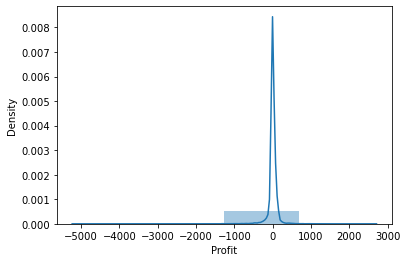

In [10]:
predictions = lm.predict(X_test)
sns.distplot((y_test - predictions), bins=4)

In [11]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns = ['Coefficients'])
coeff_df

,Coefficients
Ship Mode,-1.519527
Segment,1.009482
City,0.223339
State,0.223339
Country,0.223339
Market,0.669824
Region,-0.396454
Product ID,0.002864
Category,-0.713756
Sub-Category,-2.374444


### Análise dos coeficientes
Pela análise dos coeficientes, podemos ver se a influência que cada categoria tem no modelo final. Posteriormente faremos mais análises.

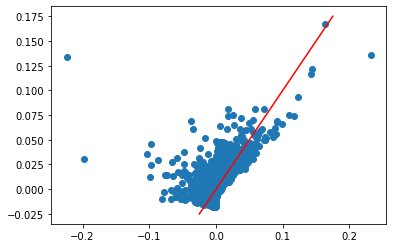

C:\Users\Diogo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


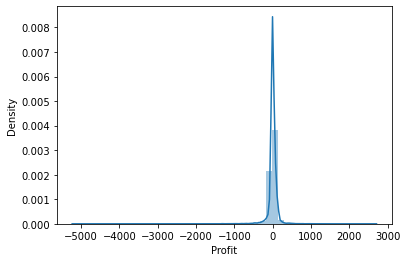

In [12]:
# Normalizar os dados para os gráficos terem a mesma grandeza.
normalize = True
from sklearn import preprocessing

ax = plt.axes()
if normalize: 
    
    y_test_norm = preprocessing.normalize([y_test])
    predictions_norm = preprocessing.normalize([predictions]) 
    ax.plot([-0.025, 0, 0.175], [-0.025, 0, 0.175], 'r')
    plt.scatter(y_test_norm, predictions_norm)
else: 

    ax.plot([-250, 0, 1500], [-250, 0, 1500], 'r')
    plt.scatter(y_test, predictions)

plt.show()
sns.distplot((y_test-predictions),bins=50);


A linha azul no primeiro gráfico serve para ajudar a visualizar os valores corretos, visto que os dois datasets têm diferenças.

### Análise dos gráficos

Pela análise dos 2 gráficos podemos tirar algumas conclusões:
- Acerta em muitos casos quando o valor é perto de 0 e 0.5, aproximadamente;
- Ver melhor :)

In [13]:
from sklearn import metrics

print ('MAE: ', metrics.mean_absolute_error(y_test, predictions))
print ('MSE: ', metrics.mean_squared_error(y_test, predictions))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print("Score: ", lm.score(X_test, y_test))


MAE:  57.783605340948085
MSE:  20067.993867950892
RMSE:  141.66154689241145
Score:  0.2830558774070838
